In [1]:
import numpy as np
import pickle
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

from tools.load_data import load_data

'''
This is simply a file to test the tools capability of the folder. It will be better to outsource the tools which we need.
Take an example of Tiago's and then try to run it in the corrent environment. 
Running with the correct file paths is really all that we care about. 
The scructure is something that cna be changed depending on how we package it

1 Copy over an example file, say the radius or lenghts that we want to work on
2 open that on the side and copy over the section about importing data

When we have access to the files in the way that we want them and have the data parsed, I no longer have to follow his file structure
I believe tht this will speed up development times as I will work in the way I see myself most able to work. 
This is a problem as I always have to relearn another's style but I think thats fine to do so long as I incorporate what is more powerful into my own.
Pillars of Sun and Earth. These are of the Self and the Other. A bundle of abstraction may only improve the life of that writing code
if it follows from their understanding of the abstraction itself - NO OBJECTION - not even from the computer. The abstraction is 
made to put the mind at ease that whatever is passed into it,
given the placement in the code, its environment, where it is drawing from,... these are made to reduce the mental load. But if trying to see the joints 
and attachements of the towers of earth cause a headache, its best to build from base principles. 
Its anti-gravity, the flower grows as you water it but its surface is all that matters. The reality underlies it but we are not god, we only use his tools.
And are his underlying joints also abstractions or are they real? Does the flower signify itself or the Self? Does the body? Does the brain of the body?
Letting go of the notion of time will let language flow forth. Time is the river, and fear will cauterize the river. 

'''

#Data path and data containers
file_pattern = "/home/nstrobbe/mahon336/hgcalmlSingularity/hgcal_minimal_eval_example/output/singlePhoton24-04-01/nominal/*.pkl"
file_limit = 1000
files = glob.glob(file_pattern)[:file_limit]
data, score_noise_filter, pass_noise_filter, out_gravnet = [], [], [], []

#extract data, each length is {file_limit}
for file in tqdm(files):
    temp_load_data = load_data(file) #4 returns, all tensors
    data.append(temp_load_data[0])
    score_noise_filter.append(temp_load_data[1])
    pass_noise_filter.append(temp_load_data[2])
    out_gravnet.append(temp_load_data[3])

del temp_load_data, file, files, file_pattern


100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s]


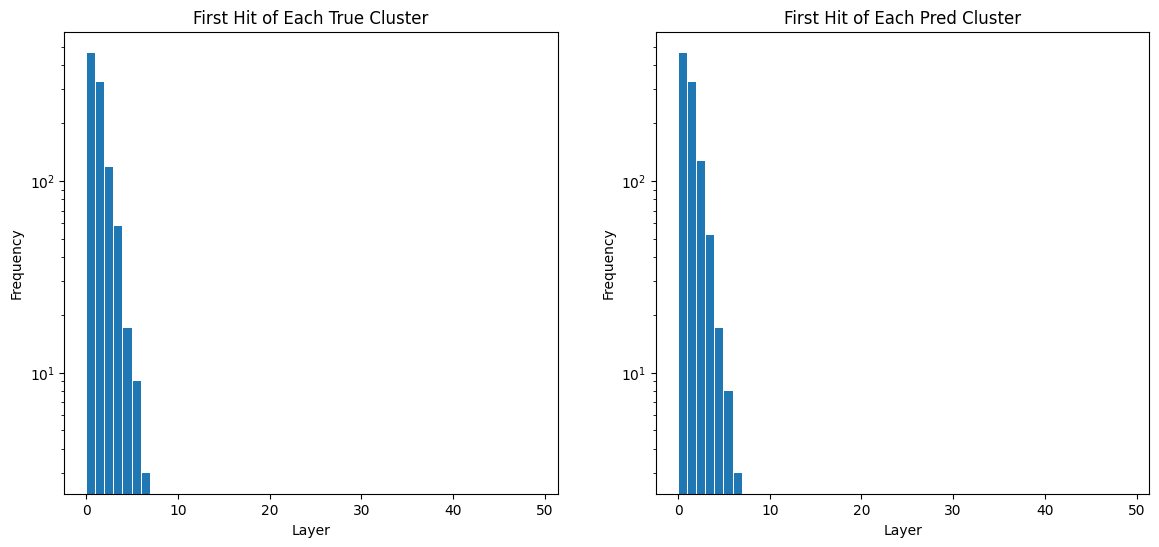

In [56]:
#data[i]: list , data[i].x: np.array()
#hence the odd indexing discrepancy

# Clustering algorithm from plots3D.
def get_clustering(beta, X, threshold_beta=0.2, threshold_dist=0.5):
    n_points = beta.shape[0]
    select_condpoints = beta > threshold_beta
    indices_condpoints = np.nonzero(select_condpoints)[0]
    indices_condpoints = indices_condpoints[np.argsort(-beta[select_condpoints])]
    unassigned = np.arange(n_points)
    clustering = -1 * np.ones(n_points, dtype=np.int32)
    
    for index_condpoint in indices_condpoints:
        d = np.linalg.norm(X[unassigned] - X[index_condpoint], axis=-1)
        assigned_to_this_condpoint = unassigned[d < threshold_dist]
        clustering[assigned_to_this_condpoint] = index_condpoint
        unassigned = unassigned[~(d < threshold_dist)]
    
    return clustering

# Parsing network output.
def process_gravnet(score_noise_filter, pass_noise_filter, out_gravnet):
    sigmoid = lambda x : (1+np.exp(-x)) ** (-1)
    beta = sigmoid(out_gravnet[:, 0])
    cluster_space_coords = out_gravnet[:, 1:].numpy()
    pred_clusters_pnf = get_clustering(beta, cluster_space_coords, threshold_beta=0.2, threshold_dist=0.5)
    pred_clusters = np.zeros_like(pass_noise_filter, dtype=np.int32)
    pred_clusters[pass_noise_filter] = pred_clusters_pnf
    
    # Count hits per cluster
    unique, counts = np.unique(pred_clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    
    # Create final_pred_hits with clusters having less than 100 hits labeled as -2
    final_pred_hits = np.array([cluster if cluster_counts[cluster] >= 100 else -2 for cluster in pred_clusters])
    
    return final_pred_hits




#Data processing
z_pos = np.array([ data[i].x[:,7] for i in range(file_limit) ], dtype=object)
unique_z = np.unique(np.round(np.concatenate(([np.unique(event) for event in z_pos]))))
true_cluster = np.array([ data[i].y for i in range(file_limit)], dtype=object)
final_pred_hits = np.array([ process_gravnet(score_noise_filter[i], pass_noise_filter[i], out_gravnet[i]) for i in range(file_limit)], dtype=object)



#PREDICTION PROCESSING
#Mask all hits for all events for noise, get the first hit in z_pos, find the corresponding layer
z_pred_clean = np.array([ z_pos[i][final_pred_hits[i] > 0] for i in range(file_limit)], dtype=object)
firstZ_pred = np.array([ np.round(sorted(z_pred_clean[i])[0]) for i in range(file_limit) ])
firstLayer_pred = [np.argwhere(firstZ_pred[i]==unique_z)[0][0] for i in range(file_limit)]

#TRUTH PROCESSING
#Mask all hits for all events for noise, get the first hit in z_pos, find the corresponding layer
z_true_clean = np.array([ z_pos[i][true_cluster[i] == True] for i in range(file_limit)], dtype=object)
firstZ_true = np.array([ np.round(sorted(z_true_clean[i])[0]) for i in range(file_limit) ])
firstLayer_true = [np.argwhere(firstZ_true[i]==unique_z)[0][0] for i in range(file_limit) ] 

# #plotting
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(14)
fig.set_figheight(6)
fig.tight_layout
axs[0].hist(firstLayer_true, range(50), rwidth=0.90)
axs[0].set_ylabel("Frequency")
axs[0].set_yscale("log")
axs[0].set_xlabel("Layer")
axs[0].set_title("First Hit of Each True Cluster")
axs[1].hist(firstLayer_pred, range(50), rwidth=0.90)
axs[1].set_ylabel("Frequency")
axs[1].set_yscale("log")
axs[1].set_xlabel("Layer")
axs[1].set_title("First Hit of Each Pred Cluster")



plt.show()


In [53]:
beta = np.array([torch.sigmoid(out_gravnet[i][:,0]) for i in range(file_limit)], dtype=object)
sigme = lambda x : (1 + np.exp(-x)) ** (-1)
beta2 = np.array([  sigme(out_gravnet[i][:,0]) for i in range(file_limit)], dtype=object)

diff = np.array([(beta[i]-beta2[i]) ** 2 for i in range(1000)], dtype=object)
# plt.plot(diff)
# plt.show()
np.max(np.concatenate(diff))

/tmp/ipykernel_573344/1448574183.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sigme = lambda x : (1 + np.exp(-x)) ** (-1)


np.float32(1.4210855e-14)